In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from ta.trend import EMAIndicator, MACD, ADXIndicator
from ta.momentum import RSIIndicator
from ta.volatility import AverageTrueRange
from ta.volume import OnBalanceVolumeIndicator
import matplotlib.pyplot as plt

In [2]:

data = yf.download('AAPL', start='2010-01-01', end='2023-12-31')
data.columns = data.columns.droplevel(0)
data.columns = ['Close', 'High', 'Low', 'Open', 'Volume']

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [3]:
data

,Close,High,Low,Open,Volume
Date,,,,,
2010-01-04,6.431897,6.446623,6.382908,6.414465,493729600
2010-01-05,6.443016,6.479382,6.409054,6.449628,601904800
2010-01-06,6.340531,6.468562,6.333919,6.443016,552160000
2010-01-07,6.328810,6.371487,6.282827,6.363974,477131200
2010-01-08,6.370885,6.371486,6.283127,6.320394,447610800
...,...,...,...,...,...
2023-12-22,192.192566,193.989405,191.567141,193.761066,37122800
2023-12-26,191.646561,192.480450,191.428159,192.202487,28919300
2023-12-27,191.745819,192.093281,189.700797,191.090629,48087700


In [4]:








# Feature engineering function updated for price prediction
def create_feature_target(df):
    df = df.copy()
    N_STEPS_AHEAD = 10
    # Target: next day's closing price
    for i in range(1, N_STEPS_AHEAD + 1):
        df[f'next_close+{i}'] = df['Close'].shift(-i)
    
    # Volatility features
    df['atr_14'] = AverageTrueRange(df['High'], df['Low'], df['Close'], window=14).average_true_range()
    df['vol_ratio'] = df['atr_14'] / df['atr_14'].rolling(50).mean()
    
    # Price action features
    df['range_pct'] = (df['High'] - df['Low']) / df['Open']
    df['close_open_ratio'] = (df['Close'] - df['Open']) / df['Open']
    
    # Trend indicators
    df['ema_50'] = EMAIndicator(df['Close'], window=50).ema_indicator()
    macd = MACD(df['Close'])
    df['macd'] = macd.macd()
    df['macd_signal'] = macd.macd_signal()
    df['adx_14'] = ADXIndicator(df['High'], df['Low'], df['Close'], window=14).adx()
    
    # Momentum indicators
    df['rsi_14'] = RSIIndicator(df['Close'], window=14).rsi()
    
    # Volume-based features
    df['on_balance_volume'] = OnBalanceVolumeIndicator(df['Close'], df['Volume']).on_balance_volume()
    df['volume_ma_20'] = df['Volume'].rolling(20).mean()
    
    # Buying/selling pressure features
    df['bid_ask_imbalance'] = (df['Close'] - df['Low']) / (df['High'] - df['Low'] + 1e-10)
    
    # Volume directionality
    df['volume_direction'] = np.where(df['Close'] > df['Open'], df['Volume'], -df['Volume'])
    df['vwd_5'] = df['volume_direction'].rolling(5).mean()
    
    # Delta volume profiles
    df['up_volume'] = np.where(df['Close'] > df['Close'].shift(1), df['Volume'], 0)
    df['down_volume'] = np.where(df['Close'] < df['Close'].shift(1), df['Volume'], 0)
    df['up_volume_ma'] = df['up_volume'].rolling(10).mean()
    df['down_volume_ma'] = df['down_volume'].rolling(10).mean()
    df['volume_ratio'] = df['up_volume_ma'] / (df['down_volume_ma'] + 1e-10)
    
    # Candlestick patterns
    df['bullish_engulfing'] = np.where(
        (df['Close'] > df['Open'].shift(1)) & 
        (df['Open'] < df['Close'].shift(1)) &
        (df['Open'] < df['Close']) & 
        (df['Close'] > df['Open']),
        1, 0
    )
    
    df['volume_spike'] = np.where(df['Volume'] > 2 * df['volume_ma_20'], 1, 0)
    
    # Drop rows with NaNs
    df.dropna(inplace=True)
    
    # Define feature columns
    feature_cols = ['Close', 'Open', 'High', 'Low', 'Volume',
                    'atr_14', 'vol_ratio', 'range_pct', 'close_open_ratio',
                    'ema_50', 'macd', 'macd_signal', 'adx_14', 'rsi_14',
                    'on_balance_volume', 'volume_ma_20', 'bid_ask_imbalance',
                    'vwd_5', 'up_volume_ma', 'down_volume_ma', 'volume_ratio',
                    'bullish_engulfing', 'volume_spike']
    target_cols = [f'next_close+{i}' for i in range(1, N_STEPS_AHEAD + 1)]
    available_cols = [col for col in feature_cols + target_cols if col in df.columns]
    df.dropna(subset=target_cols, inplace=True)
    return df[available_cols ] 

feature_df = create_feature_target(data)

In [5]:
feature_df

,Close,Open,High,Low,Volume,atr_14,vol_ratio,range_pct,close_open_ratio,ema_50,...,next_close+1,next_close+2,next_close+3,next_close+4,next_close+5,next_close+6,next_close+7,next_close+8,next_close+9,next_close+10
Date,,,,,,,,,,,,,,,,,,,,,
2010-03-16,6.745663,6.737548,6.761591,6.687358,446908000,0.126213,1.087979,0.011018,0.001204,6.316458,...,6.735746,6.751674,6.679542,6.754679,6.863173,6.893528,6.811781,6.939512,6.984291,7.088281
2010-03-17,6.735746,6.759188,6.805772,6.710200,450956800,0.124025,1.046731,0.014140,-0.003468,6.332900,...,6.751674,6.679542,6.754679,6.863173,6.893528,6.811781,6.939512,6.984291,7.088281,7.062733
2010-03-18,6.751674,6.735144,6.762193,6.690363,342109600,0.120296,0.995061,0.010665,0.002454,6.349323,...,6.679542,6.754679,6.863173,6.893528,6.811781,6.939512,6.984291,7.088281,7.062733,7.091885
2010-03-19,6.679542,6.755879,6.769404,6.648886,559445600,0.120312,0.975770,0.017839,-0.011299,6.362273,...,6.754679,6.863173,6.893528,6.811781,6.939512,6.984291,7.088281,7.062733,7.091885,7.167622
2010-03-22,6.754679,6.626048,6.792247,6.616430,456419600,0.124277,0.988008,0.026534,0.019413,6.377661,...,6.863173,6.893528,6.811781,6.939512,6.984291,7.088281,7.062733,7.091885,7.167622,7.199182
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-08,194.287216,192.788184,194.565179,192.262038,53377300,2.775150,0.885077,0.011946,0.007776,183.092929,...,191.775620,193.294495,196.520859,196.669769,196.133698,194.465897,195.508270,193.413605,193.264694,192.192566
2023-12-11,191.775620,191.706136,192.083379,190.028420,60943700,2.881125,0.922821,0.010719,0.000362,183.433427,...,193.294495,196.520859,196.669769,196.133698,194.465897,195.508270,193.413605,193.264694,192.192566,191.646561
2023-12-12,193.294495,191.676340,193.304416,190.326226,52696900,2.888058,0.928900,0.015538,0.008442,183.820135,...,196.520859,196.669769,196.133698,194.465897,195.508270,193.413605,193.264694,192.192566,191.646561,191.745819


In [6]:

X = feature_df.drop(['next_close+1',	'next_close+2',	'next_close+3',	'next_close+4',	'next_close+5',	'next_close+6',	'next_close+7',	'next_close+8'	,'next_close+9',	'next_close+10'],axis=1)
y = feature_df[['next_close+1',	'next_close+2',	'next_close+3',	'next_close+4',	'next_close+5',	'next_close+6',	'next_close+7',	'next_close+8'	,'next_close+9',	'next_close+10']]
																

In [7]:
X

,Close,Open,High,Low,Volume,atr_14,vol_ratio,range_pct,close_open_ratio,ema_50,...,rsi_14,on_balance_volume,volume_ma_20,bid_ask_imbalance,vwd_5,up_volume_ma,down_volume_ma,volume_ratio,bullish_engulfing,volume_spike
Date,,,,,,,,,,,,,,,,,,,,,
2010-03-16,6.745663,6.737548,6.761591,6.687358,446908000,0.126213,1.087979,0.011018,0.001204,6.316458,...,70.350736,8171570400,516832960.0,0.785425,107800000.0,485301320.0,49350280.0,9.833811,0,0
2010-03-17,6.735746,6.759188,6.805772,6.710200,450956800,0.124025,1.046731,0.014140,-0.003468,6.332900,...,69.559635,7720613600,517560960.0,0.267295,-101634960.0,448096040.0,94445960.0,4.744470,0,0
2010-03-18,6.751674,6.735144,6.762193,6.690363,342109600,0.120296,0.995061,0.010665,0.002454,6.349323,...,70.140439,8062723200,513525180.0,0.853559,-114353120.0,445702880.0,94445960.0,4.719131,0,0
2010-03-19,6.679542,6.755879,6.769404,6.648886,559445600,0.120312,0.975770,0.017839,-0.011299,6.362273,...,64.169333,7503277600,520723980.0,0.254366,-142977520.0,355740840.0,150390520.0,2.365447,0,0
2010-03-22,6.754679,6.626048,6.792247,6.616430,456419600,0.124277,0.988008,0.026534,0.019413,6.377661,...,67.292821,7959697200,524016780.0,0.786323,47006960.0,358393840.0,150390520.0,2.383088,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-08,194.287216,192.788184,194.565179,192.262038,53377300,2.775150,0.885077,0.011946,0.007776,183.092929,...,70.107987,18943444300,47285975.0,0.879311,16600840.0,30037250.0,16804600.0,1.787442,1,0
2023-12-11,191.775620,191.706136,192.083379,190.028420,60943700,2.881125,0.922821,0.010719,0.000362,183.433427,...,62.184724,18882500600,47026490.0,0.850236,37467480.0,30037250.0,18843710.0,1.594020,0,0
2023-12-12,193.294495,191.676340,193.304416,190.326226,52696900,2.888058,0.928900,0.015538,0.008442,183.820135,...,64.777215,18935197500,47479960.0,0.996668,34681180.0,31465400.0,18843710.0,1.669809,1,0


In [8]:

train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]
dates = feature_df.index[train_size:]

In [9]:
# Feature scaling
feature_scaler = MinMaxScaler(feature_range=(0, 1))
X_train_scaled = feature_scaler.fit_transform(X_train)
X_test_scaled = feature_scaler.transform(X_test)

# Target scaling
target_scaler = MinMaxScaler(feature_range=(0, 1))
y_train_scaled = target_scaler.fit_transform(y_train)
y_test_scaled = target_scaler.transform(y_test)

In [10]:

SEQ_LENGTH = 60


def create_sequences(data, prices):
    X_seq, y_seq = [], []
    for i in range(SEQ_LENGTH, len(data)):
        X_seq.append(data[i-SEQ_LENGTH:i])
        y_seq.append(prices[i])  # Target is the next return
    return np.array(X_seq), np.array(y_seq)



X_train_seq, y_train_seq = create_sequences(
    X_train_scaled, y_train_scaled
)
X_test_seq, y_test_seq = create_sequences(
    X_test_scaled, y_test_scaled
)

In [11]:
# Build final model
final_model = Sequential([
    
    GRU(128, return_sequences=True,
        kernel_regularizer=l2(0.0001),
        input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])),
    Dropout(0.2),
    
    GRU(32, kernel_regularizer=l2(0.0001)),
    Dropout(0.2),
    Dense(10)
])

final_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='mse'
)

C:\Users\Mudit\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [12]:

history = final_model.fit(
    X_train_seq, y_train_seq,
    epochs=100,
    batch_size=32,
    validation_data=(X_test_seq, y_test_seq),
    callbacks=[EarlyStopping(patience=10, restore_best_weights=True)],
    verbose=1
)

Epoch 1/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 15s 86ms/step - loss: 0.0457 - val_loss: 0.0572
Epoch 2/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 8s 86ms/step - loss: 0.0134 - val_loss: 0.0228
Epoch 3/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 6s 67ms/step - loss: 0.0088 - val_loss: 0.0223
Epoch 4/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 6s 70ms/step - loss: 0.0075 - val_loss: 0.0099
Epoch 5/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 6s 70ms/step - loss: 0.0064 - val_loss: 0.0119
Epoch 6/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 6s 74ms/step - loss: 0.0055 - val_loss: 0.0106
Epoch 7/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 6s 70ms/step - loss: 0.0052 - val_loss: 0.0111
Epoch 8/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 7s 87ms/step - loss: 0.0045 - val_loss: 0.0091
Epoch 9/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 7s 80ms/step - loss: 0.0042 - val_loss: 0.0063
Epoch 10/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 6s 67ms/step - loss: 0.0034 - val_loss: 0.0062
Epoch 11/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 6s 76ms/step - loss: 0.0033 - val_loss: 0.0071
Epoch 12/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 7s 87ms/ste

In [219]:
final_model.save("final_apple_model.keras")

In [13]:

train_predict = final_model.predict(X_train_seq)
test_predict = final_model.predict(X_test_seq)


train_predict = target_scaler.inverse_transform(train_predict)
y_train_actual = target_scaler.inverse_transform(y_train_seq)
test_predict = target_scaler.inverse_transform(test_predict)
y_test_actual = target_scaler.inverse_transform(y_test_seq)

85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


In [14]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [15]:

test_rmse = np.sqrt(mean_squared_error(y_test_actual, test_predict))
test_mae = mean_absolute_error(y_test_actual, test_predict)
test_r2 = r2_score(y_test_actual, test_predict)

print(f"Test RMSE: {test_rmse:.4f}")
print(f"Test MAE: {test_mae:.4f}")
print(f"Test R²: {test_r2:.4f}")

Test RMSE: 7.1959
Test MAE: 5.8097
Test R²: 0.8269


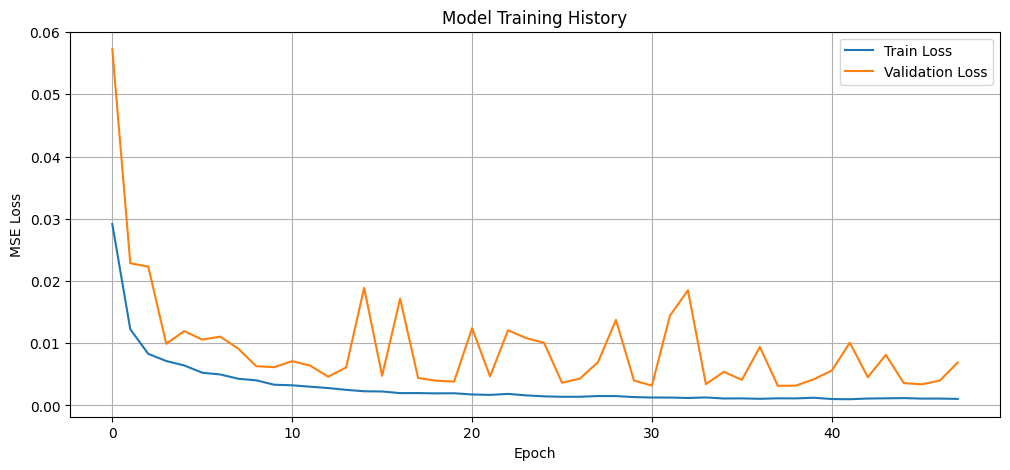

In [16]:

plt.figure(figsize=(12, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Training History')
plt.ylabel('MSE Loss')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)
plt.show()

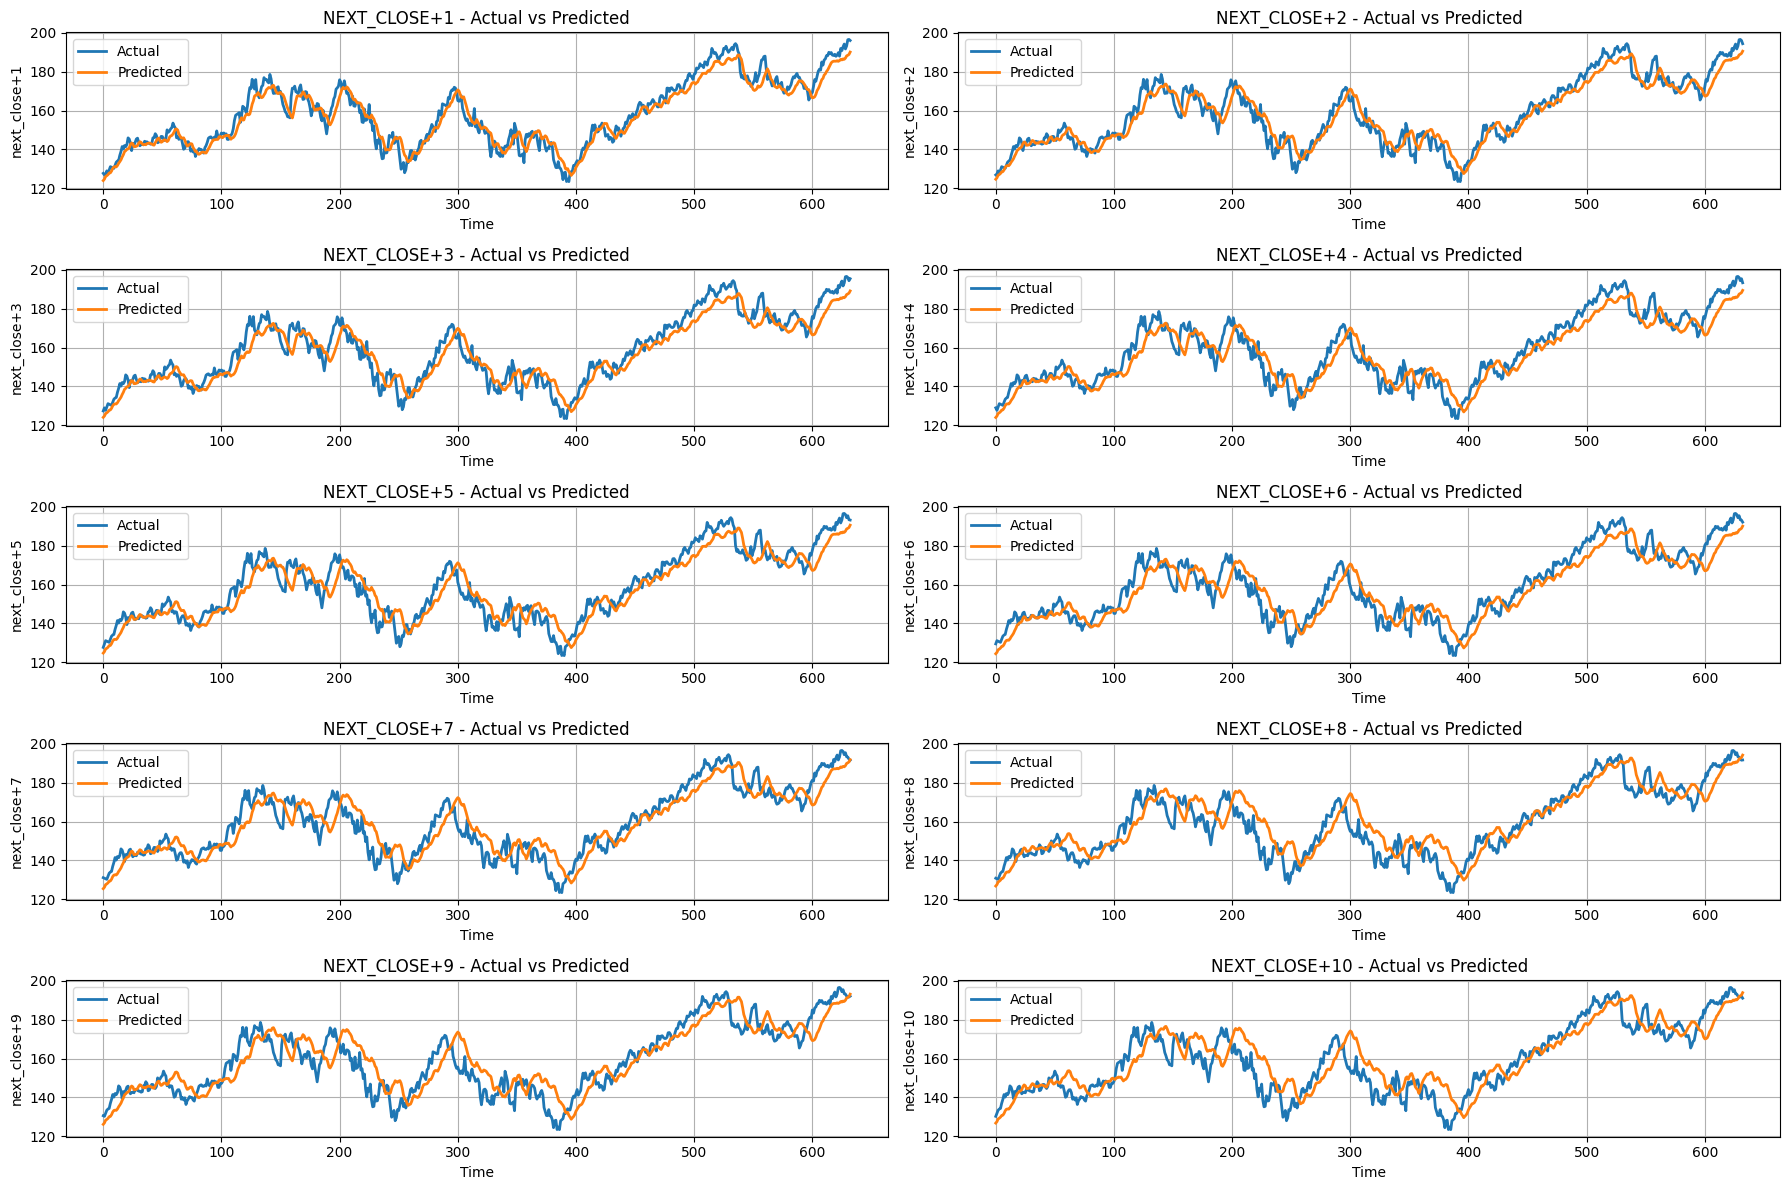

In [17]:
# Plot predicted vs actual prices for test set
# Plot predicted vs actual prices for test set
import matplotlib.pyplot as plt

# Plot each target
plt.figure(figsize=(18, 12))
for i, name in enumerate(y):
    plt.subplot(5, 2, i+1)
    plt.plot(y_test_actual[:, i], label='Actual', linewidth=2)
    plt.plot(test_predict[:, i], label='Predicted', linewidth=2)
    plt.title(f'{name.upper()} - Actual vs Predicted')
    plt.xlabel('Time')
    plt.ylabel(name)
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()


In [18]:
test_data = yf.download('AAPL', start='2023-08-01')
#test_data.columns = data.columns.droplevel(0)
test_data.columns = ['Close', 'High', 'Low', 'Open', 'Volume'] 

[*********************100%***********************]  1 of 1 completed


In [19]:
test_data

,Close,High,Low,Open,Volume
Date,,,,,
2023-08-01,193.670914,194.779806,193.344183,194.294673,35175100
2023-08-02,190.670959,193.245177,189.948200,193.106565,50389300
2023-08-03,189.274918,190.463019,188.799680,189.670961,61235200
2023-08-04,180.185944,185.522512,180.116630,183.680950,115799700
2023-08-07,177.077057,181.314628,175.591926,180.324541,97576100
...,...,...,...,...,...
2025-06-23,201.500000,202.300003,198.960007,201.630005,55814300
2025-06-24,200.300003,203.440002,200.199997,202.589996,54064000
2025-06-25,201.559998,203.669998,200.619995,201.449997,39525700


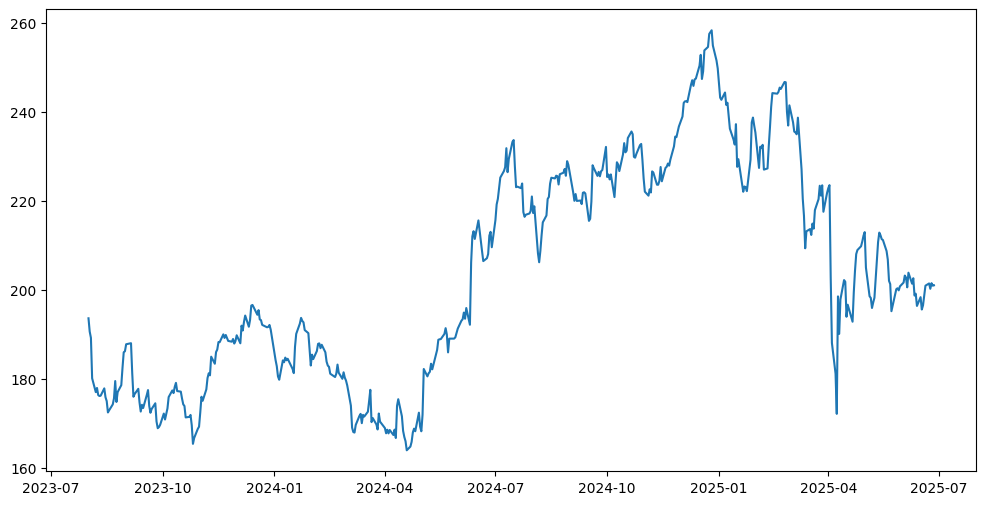

In [20]:
# Plot results
plt.figure(figsize=(12, 6))
plt.plot( test_data['Close'], label='Actual Next Close')

In [21]:
test_feature_df = create_feature_target(test_data)

In [22]:
test_feature_df

,Close,Open,High,Low,Volume,atr_14,vol_ratio,range_pct,close_open_ratio,ema_50,...,next_close+1,next_close+2,next_close+3,next_close+4,next_close+5,next_close+6,next_close+7,next_close+8,next_close+9,next_close+10
Date,,,,,,,,,,,,,,,,,,,,,
2023-10-10,176.860123,176.572616,178.178718,176.423894,43698000,3.388759,1.294116,0.009938,0.001628,178.030649,...,178.258041,179.160233,177.316177,177.187271,175.630753,174.331985,173.955246,171.397369,171.516342,171.952560
2023-10-11,178.258041,176.671757,178.307616,176.076912,47551100,3.306041,1.231433,0.012626,0.008979,178.039567,...,179.160233,177.316177,177.187271,175.630753,174.331985,173.955246,171.397369,171.516342,171.952560,169.632645
2023-10-12,179.160233,178.525722,180.776243,177.504541,56743100,3.303588,1.200963,0.018326,0.003554,178.083514,...,177.316177,177.187271,175.630753,174.331985,173.955246,171.397369,171.516342,171.952560,169.632645,165.458725
2023-10-13,177.316177,179.864129,180.369750,176.612260,51427100,3.336010,1.184030,0.020891,-0.014166,178.053423,...,177.187271,175.630753,174.331985,173.955246,171.397369,171.516342,171.952560,169.632645,165.458725,166.777344
2023-10-16,177.187271,175.234165,177.544184,174.996218,52517000,3.279721,1.137568,0.014540,0.011146,178.019456,...,175.630753,174.331985,173.955246,171.397369,171.516342,171.952560,169.632645,165.458725,166.777344,168.829575
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-06,203.919998,203.000000,205.699997,202.050003,46607700,5.274677,0.675935,0.017980,0.004532,206.787505,...,201.449997,202.669998,198.779999,199.199997,196.449997,198.419998,195.639999,196.580002,201.000000,201.500000
2025-06-09,201.449997,204.389999,206.000000,200.020004,72862600,5.325057,0.683303,0.029258,-0.014384,206.578191,...,202.669998,198.779999,199.199997,196.449997,198.419998,195.639999,196.580002,201.000000,201.500000,200.300003
2025-06-10,202.669998,200.600006,204.350006,200.570007,54672600,5.214695,0.670266,0.018843,0.010319,206.424929,...,198.779999,199.199997,196.449997,198.419998,195.639999,196.580002,201.000000,201.500000,200.300003,201.559998


In [23]:
test_X = test_feature_df.drop(['next_close+1',	'next_close+2',	'next_close+3',	'next_close+4',	'next_close+5',	'next_close+6',	'next_close+7',	'next_close+8'	,'next_close+9',	'next_close+10'], axis=1).values

In [24]:
test_X_scaled = feature_scaler.transform(test_X)

C:\Users\Mudit\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


In [25]:
SEQ_LENGTH = 60
if len(test_X_scaled) < SEQ_LENGTH:
        raise ValueError("Not enough data to make a prediction.")

predictions = []
actuals = []
dates = []
shifted_close = test_feature_df[['next_close+1',	'next_close+2',	'next_close+3',	'next_close+4',	'next_close+5',	'next_close+6',	'next_close+7',	'next_close+8'	,'next_close+9',	'next_close+10']].values  # same as your 'next_close'

for i in range(SEQ_LENGTH, len(test_X_scaled)):
    latest_seq = test_X_scaled[i - SEQ_LENGTH:i]
    input_seq = np.expand_dims(latest_seq, axis=0)  # shape (1, 60, features)

    pred_scaled = final_model.predict(input_seq, verbose=0)
    pred_actual = target_scaler.inverse_transform(pred_scaled)

    predictions.append(pred_actual.flatten())  # scalar value
    actuals.append(shifted_close[i])
    dates.append(test_feature_df.index[i]) 



In [26]:
pred_actual

array([[200.09843, 200.78976, 199.28116, 199.59335, 200.67686, 200.42447,
        202.43706, 204.86182, 203.42932, 204.33958]], dtype=float32)

In [27]:
predictions = np.array(predictions)  # shape (N, 5)
actuals = np.array(actuals) 

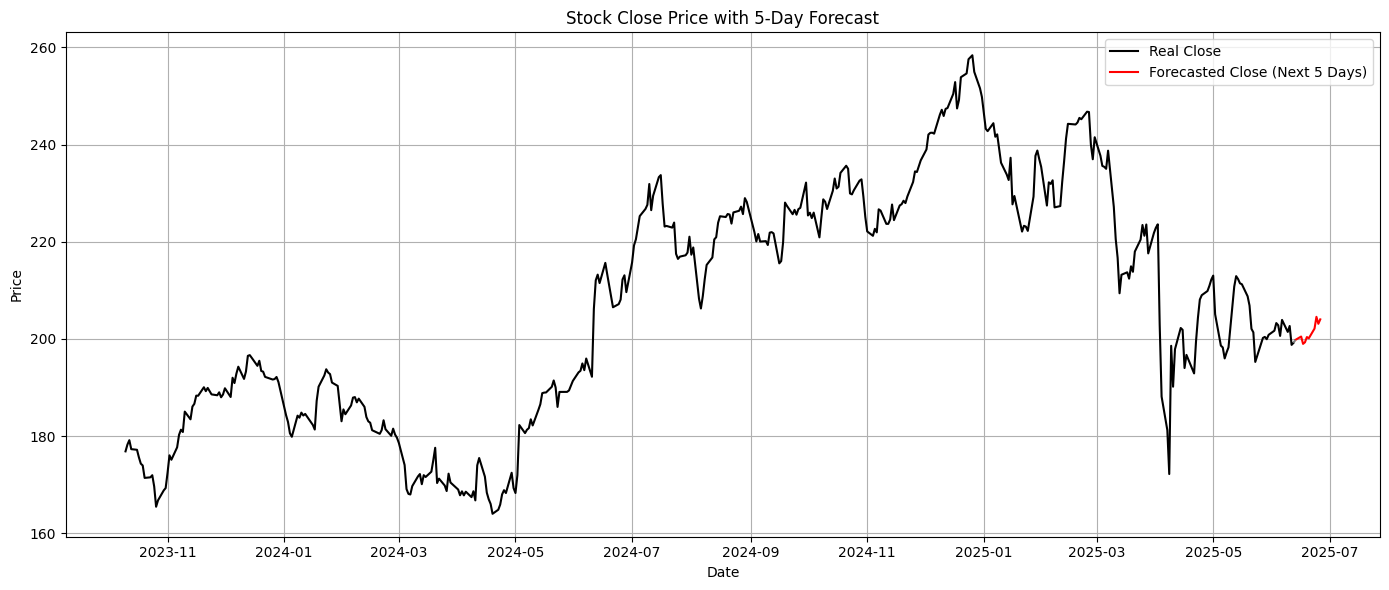

In [28]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Get the last 30-day sequence from test set
last_seq = test_X_scaled[-SEQ_LENGTH:]
input_seq = np.expand_dims(last_seq, axis=0)

# Predict next 5-day prices
pred_scaled = final_model.predict(input_seq, verbose=0)  # shape: (1, 5)
pred_actual = target_scaler.inverse_transform(pred_scaled).flatten()  # shape: (5,)

# Actual close prices
real_close = test_feature_df['Close'].values

# Generate future dates
last_date = test_feature_df.index[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=10, freq='B')  # business days

# Create plot
plt.figure(figsize=(14, 6))
plt.plot(test_feature_df.index, real_close, label='Real Close', color='black')

# Plot the predicted values after the actual close
plt.plot(future_dates, pred_actual, label='Forecasted Close (Next 5 Days)', color='red')

# Combine last actual and first prediction for a smooth line
plt.plot([test_feature_df.index[-1], future_dates[0]],
         [real_close[-1], pred_actual[0]], color='gray', linestyle='--')

plt.title("Stock Close Price with 5-Day Forecast")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


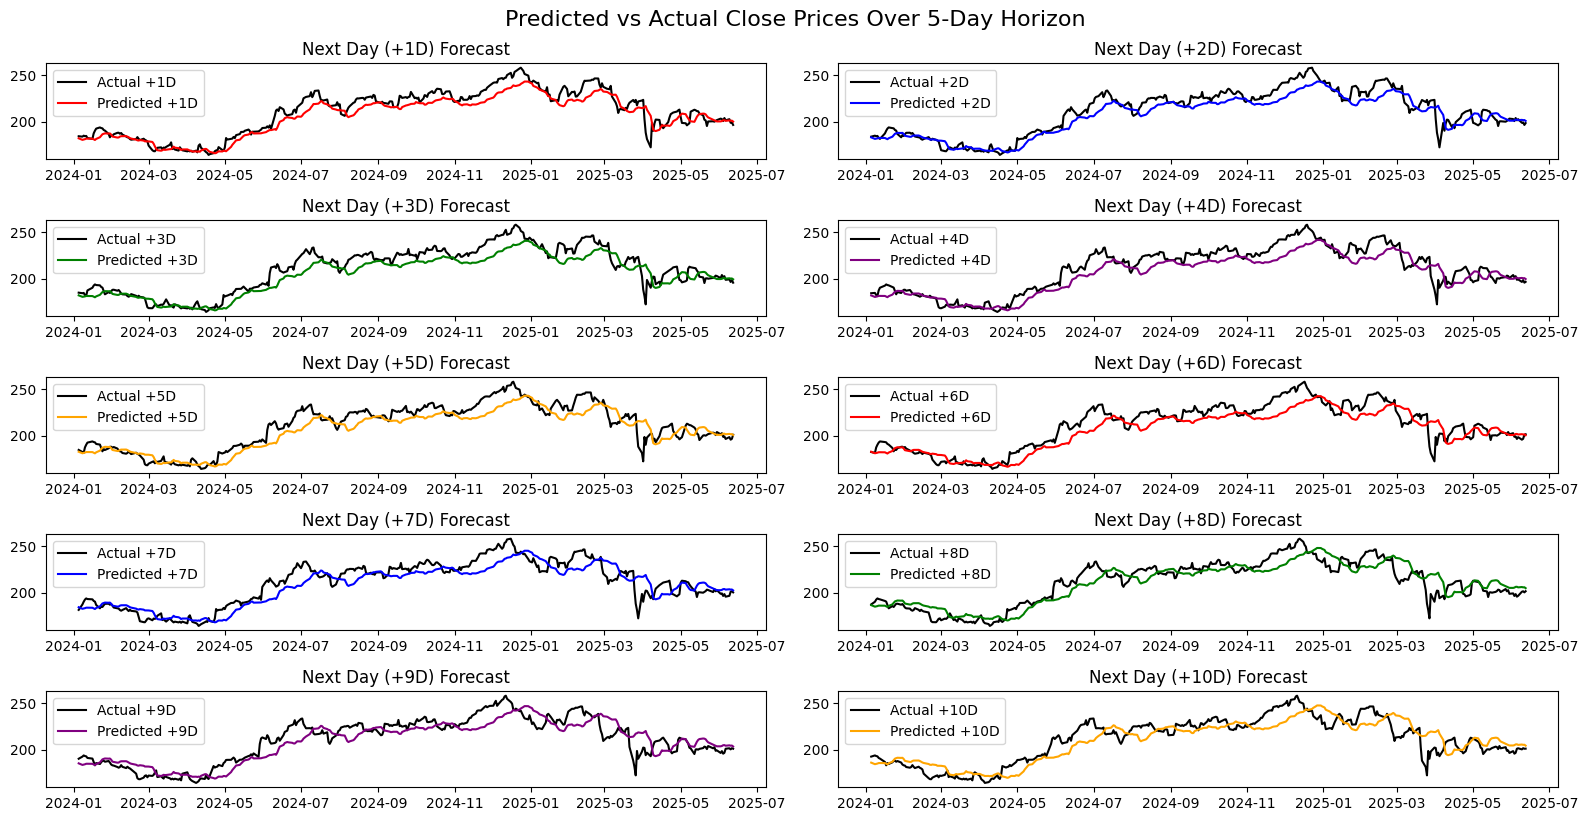

In [29]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 8))

# Day +1 Prediction
plt.subplot(5, 2, 1)
plt.plot(dates, actuals[:, 0], label='Actual +1D', color='black')
plt.plot(dates, predictions[:, 0], label='Predicted +1D', color='red')
plt.title('Next Day (+1D) Forecast')
plt.legend()

# Day +2 Prediction
plt.subplot(5, 2, 2)
plt.plot(dates, actuals[:, 1], label='Actual +2D', color='black')
plt.plot(dates, predictions[:, 1], label='Predicted +2D', color='blue')
plt.title('Next Day (+2D) Forecast')
plt.legend()

# Day +3 Prediction
plt.subplot(5, 2, 3)
plt.plot(dates, actuals[:, 2], label='Actual +3D', color='black')
plt.plot(dates, predictions[:, 2], label='Predicted +3D', color='green')
plt.title('Next Day (+3D) Forecast')
plt.legend()

# Day +4 Prediction
plt.subplot(5, 2, 4)
plt.plot(dates, actuals[:, 3], label='Actual +4D', color='black')
plt.plot(dates, predictions[:, 3], label='Predicted +4D', color='purple')
plt.title('Next Day (+4D) Forecast')
plt.legend()

# Day +5 Prediction
plt.subplot(5, 2, 5)
plt.plot(dates, actuals[:, 4], label='Actual +5D', color='black')
plt.plot(dates, predictions[:, 4], label='Predicted +5D', color='orange')
plt.title('Next Day (+5D) Forecast')
plt.legend()

# Day +1 Prediction
plt.subplot(5, 2, 6)
plt.plot(dates, actuals[:, 5], label='Actual +6D', color='black')
plt.plot(dates, predictions[:, 5], label='Predicted +6D', color='red')
plt.title('Next Day (+6D) Forecast')
plt.legend()

# Day +2 Prediction
plt.subplot(5, 2, 7)
plt.plot(dates, actuals[:, 6], label='Actual +7D', color='black')
plt.plot(dates, predictions[:, 6], label='Predicted +7D', color='blue')
plt.title('Next Day (+7D) Forecast')
plt.legend()

# Day +3 Prediction
plt.subplot(5, 2, 8)
plt.plot(dates, actuals[:, 7], label='Actual +8D', color='black')
plt.plot(dates, predictions[:, 7], label='Predicted +8D', color='green')
plt.title('Next Day (+8D) Forecast')
plt.legend()

# Day +4 Prediction
plt.subplot(5, 2, 9)
plt.plot(dates, actuals[:, 8], label='Actual +9D', color='black')
plt.plot(dates, predictions[:, 8], label='Predicted +9D', color='purple')
plt.title('Next Day (+9D) Forecast')
plt.legend()

# Day +5 Prediction
plt.subplot(5, 2, 10)
plt.plot(dates, actuals[:, 9], label='Actual +10D', color='black')
plt.plot(dates, predictions[:, 9], label='Predicted +10D', color='orange')
plt.title('Next Day (+10D) Forecast')
plt.legend()

plt.tight_layout()
plt.suptitle("Predicted vs Actual Close Prices Over 5-Day Horizon", fontsize=16, y=1.02)
plt.show()


In [161]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def backtest_model(new_data_df, scaled_features, model, feature_scaler, target_scaler,
                   seq_length, slippage, commission, initial_balance,
                   stop_loss_pct, target_profit_pct, csv_filename,
                   capital_percentage,target_profit):  # Changed to percentage

    balance = initial_balance
    returns = []
    equity_curve = [initial_balance]  # Start with initial balance
    trade_log = []
    position_exit_idx = -1  # Track until which index a trade is open
    min_trade_size = 10  # Minimum trade size in dollars to avoid tiny trades

    for i in range(seq_length, len(scaled_features) - 5):
        # Prevent new trade if one is still open
        if i <= position_exit_idx:
            continue

        current_close = new_data_df['Close'].iloc[i]
        input_seq = np.expand_dims(scaled_features[i - seq_length:i], axis=0)
        pred_scaled = model.predict(input_seq, verbose=0)
        predicted_close = target_scaler.inverse_transform(pred_scaled).flatten()

        max_upside = (predicted_close.max() - current_close) / current_close
        max_downside = (predicted_close.min() - current_close) / current_close

        signal = None
        if max_upside >= target_profit_pct:
            signal = 'buy'
        elif max_downside <= -target_profit_pct:
            signal = 'sell'

        if signal:
            entry_idx = i + 1
            if entry_idx >= len(new_data_df):
                continue
            entry_price = new_data_df['Open'].iloc[entry_idx]
            entry_date = new_data_df.index[entry_idx]

            if signal == 'buy':
                adj_entry = entry_price * (1 + slippage)
                stop_loss_price = adj_entry * (1 - stop_loss_pct)
                target_price = adj_entry * (1 + target_profit)
            else:
                adj_entry = entry_price * (1 - slippage)
                stop_loss_price = adj_entry * (1 + stop_loss_pct)
                target_price = adj_entry * (1 - target_profit)

            # Calculate trade size as percentage of current balance
            trade_capital = balance * capital_percentage
            
            # Skip if trade capital is below minimum threshold
            if trade_capital < min_trade_size:
                continue
                
            # Calculate maximum integer shares we can buy with the allocated capital
            num_shares = int(trade_capital // adj_entry)
            if num_shares == 0:
                continue
                
            used_capital = num_shares * adj_entry
            exit_idx = None
            reason = "time_exit"  # Default exit reason

            # Check exit conditions over next 5 bars
            for j in range(10):
                price_idx = entry_idx + j
                if price_idx >= len(new_data_df):
                    break
            
                high = new_data_df['High'].iloc[price_idx]
                low = new_data_df['Low'].iloc[price_idx]
            
                # Prioritize stop loss check before target profit
                if signal == 'buy':
                    if low <= stop_loss_price:
                        adj_exit = stop_loss_price * (1 - slippage)
                        exit_idx = price_idx
                        reason = "stop_loss"
                        break
                    elif high >= target_price:
                        adj_exit = target_price * (1 - slippage)
                        exit_idx = price_idx
                        reason = "target_hit"
                        break
                else:  # sell signal
                    if high >= stop_loss_price:
                        adj_exit = stop_loss_price * (1 + slippage)
                        exit_idx = price_idx
                        reason = "stop_loss"
                        break
                    elif low <= target_price:
                        adj_exit = target_price * (1 + slippage)
                        exit_idx = price_idx
                        reason = "target_hit"
                        break

            # Handle time-based exit if no SL/TP triggered
            if exit_idx is None:
                exit_idx = entry_idx + 10
                if exit_idx >= len(new_data_df):
                    exit_idx = len(new_data_df) - 1
                exit_price = new_data_df['Close'].iloc[exit_idx]
                adj_exit = exit_price * (1 - slippage) if signal == 'buy' else exit_price * (1 + slippage)

            # Mark the trade as open until exit_idx
            position_exit_idx = exit_idx
            exit_date = new_data_df.index[exit_idx]

            # Calculate PnL
            if signal == 'buy':
                gross_pnl = (adj_exit - adj_entry) * num_shares
            else:
                gross_pnl = (adj_entry - adj_exit) * num_shares

            net_pnl = gross_pnl - (2 * commission * used_capital)
            balance += net_pnl
            pnl_pct = net_pnl / used_capital
            returns.append(pnl_pct)
            equity_curve.append(balance)

            trade_log.append({
                'Entry Date': entry_date,
                'Exit Date': exit_date,
                'Signal': signal,
                'Reason': reason,
                'Entry Price': round(adj_entry, 2),
                'Exit Price': round(adj_exit, 2),
                'Shares': num_shares,  # Integer shares
                'Capital Used': round(used_capital, 2),
                'PnL $': round(net_pnl, 2),
                'PnL %': round(pnl_pct * 100, 2),
                'Balance': round(balance, 2),
                'Max upside': max_upside,
                'Max downside': max_downside
            })

    trade_df = pd.DataFrame(trade_log)
    trade_df.to_csv(csv_filename, index=False)

    total_return = (balance - initial_balance) / initial_balance
    win_rate = (trade_df['PnL $'] > 0).sum() / len(trade_df) * 100 if len(trade_df) > 0 else 0
    sharpe = (np.mean(returns) / np.std(returns)) * np.sqrt(252 / 5) if len(returns) > 1 else 0

    print(f"✅ Backtest Complete — Trades: {len(trade_df)}, Final Balance: ${round(balance, 2)}")
    print(f"Starting Balance: ${initial_balance}")
    print(f"Total Return: {total_return*100:.2f}%")
    print(f"Win Rate: {win_rate:.2f}%")
    print(f"Sharpe Ratio: {sharpe:.2f}")

    if not trade_df.empty:
        plt.figure(figsize=(12, 6))
        # Plot entire equity curve including starting balance
        plt.plot([new_data_df.index[seq_length]] + trade_df['Exit Date'].tolist(), equity_curve, 
                 label='Equity Curve', color='blue')
        plt.title("Backtest Equity Curve")
        plt.xlabel("Date")
        plt.ylabel("Portfolio Value")
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

    return trade_df, equity_curve, sharpe

In [162]:
new_data = yf.download("aapl", start="2023-07-01")
new_data.columns = ['Close', 'High', 'Low', 'Open', 'Volume']
new_feature_df = create_feature_target(new_data)
new_X = new_feature_df.drop(['next_close+1',	'next_close+2',	'next_close+3',	'next_close+4',	'next_close+5',	'next_close+6',	'next_close+7',	'next_close+8'	,'next_close+9',	'next_close+10'], axis=1).values
new_X_scaled = feature_scaler.transform(new_X)

[*********************100%***********************]  1 of 1 completed
C:\Users\Mudit\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


✅ Backtest Complete — Trades: 35, Final Balance: $125613.81
Starting Balance: $100000
Total Return: 25.61%
Win Rate: 65.71%
Sharpe Ratio: 1.35


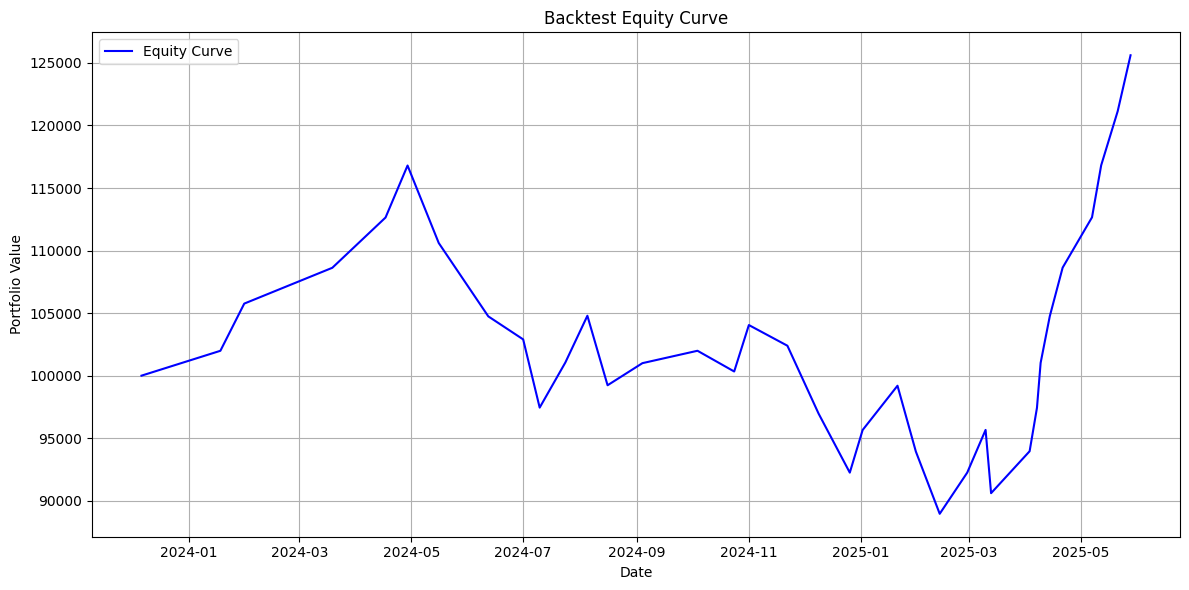

In [213]:
trade_df, equity_curve, sharpe = backtest_model(
    new_data_df=new_feature_df,
    scaled_features=new_X_scaled,
    model=final_model,
    feature_scaler=feature_scaler,
    target_scaler=target_scaler,
    seq_length=60,
    slippage=0.001,
    commission=0.001,
    initial_balance=100000,
    stop_loss_pct=0.05,
    target_profit_pct = 0.04,
    target_profit = 0.04,
    capital_percentage = 1 ,
    csv_filename="backtest_apple_day_trades.csv"
)

In [214]:
backtest_df = pd.read_csv('backtest_10_day_trades.csv')

In [215]:
backtest_df

,Entry Date,Exit Date,Signal,Reason,Entry Price,Exit Price,Shares,Capital Used,PnL $,PnL %,Balance,Max upside,Max downside
0,2023-12-07,2023-12-14,buy,target_hit,241.79,250.00,413,99859.91,3192.02,3.20,103192.02,0.044229,0.014259
1,2023-12-21,2023-12-27,buy,target_hit,252.15,260.72,409,103130.12,3296.55,3.20,106488.58,0.053515,0.021303
2,2023-12-29,2024-01-03,buy,stop_loss,255.36,239.79,417,106483.08,-6702.05,-6.29,99786.53,0.047815,0.016217
3,2024-01-05,2024-01-12,buy,stop_loss,237.10,222.65,420,99580.68,-6267.61,-6.29,93518.92,0.087544,0.057407
4,2024-01-17,2024-01-25,buy,stop_loss,215.07,201.97,434,93342.49,-5874.98,-6.29,87643.95,0.083050,0.055529
...,...,...,...,...,...,...,...,...,...,...,...,...,...
86,2025-05-12,2025-05-14,sell,stop_loss,321.67,341.31,357,114835.48,-7241.53,-6.31,107643.96,-0.024122,-0.053192
87,2025-05-16,2025-05-19,sell,target_hit,345.89,334.12,311,107572.96,3446.10,3.20,111090.06,-0.068175,-0.099937
88,2025-05-21,2025-05-22,sell,target_hit,344.09,332.37,322,110795.55,3549.34,3.20,114639.39,-0.018842,-0.052483
89,2025-05-28,2025-05-30,sell,target_hit,364.48,352.07,314,114445.20,3666.25,3.20,118305.64,-0.062497,-0.091632


In [216]:
backtest_df['Reason'].value_counts()

Reason
target_hit    63
stop_loss     27
time_exit      1
Name: count, dtype: int64

C:\Users\Mudit\AppData\Local\Temp\ipykernel_28764\2784521123.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=backtest_df, x='Reason', palette='pastel')


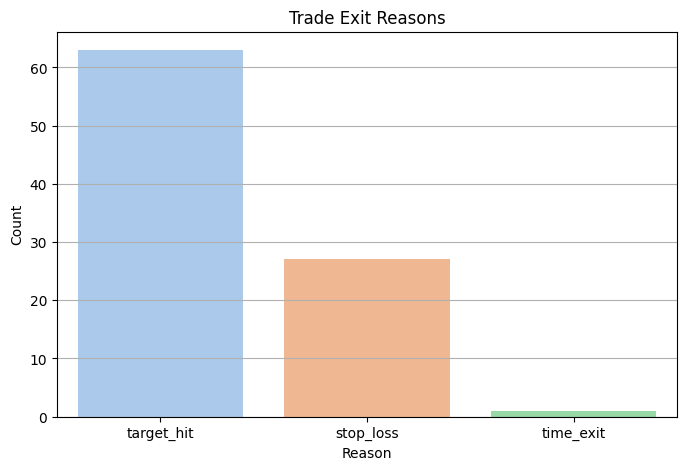

In [217]:
import seaborn as sns
plt.figure(figsize=(8, 5))
sns.countplot(data=backtest_df, x='Reason', palette='pastel')
plt.title("Trade Exit Reasons")
plt.xlabel("Reason")
plt.ylabel("Count")
plt.grid(axis='y')
plt.show()